In [1]:
from tensorflow.keras import layers, Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
import keras
import sys
import pandas as pd
import sklearn as sk
import numpy as np

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices("GPU")) > 0
print(tf.config.list_physical_devices("GPU"))
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.19.1
Keras Version: 3.12.0

Python 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Pandas 2.3.3
Scikit-Learn 1.7.2
[]
GPU is NOT AVAILABLE


In [2]:
# SEMILLA
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Parámetros
INPUT_FORMAT = (224, 224, 3)
BATCH_SIZE = 64
EPOCHS = 150
INIT_LR = 1e-4

In [4]:
preprocess_fn = tf.keras.applications.vgg16.preprocess_input


# Rutas
ruta_entrenamiento = "./data/train"
ruta_validacion = "./data/valid"
ruta_test = "./data/test"


# Generadores
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_fn,
    rotation_range=20,
    vertical_flip=True,
)
datagen_valid = ImageDataGenerator(
    preprocessing_function=preprocess_fn,
)  # ANTES APLIQUE RESCALE
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_fn,
)

generador_entrenamiento = datagen.flow_from_directory(
    ruta_entrenamiento,
    target_size=INPUT_FORMAT[:2],
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode="categorical",
)

generador_validacion = datagen_valid.flow_from_directory(
    ruta_validacion,
    target_size=INPUT_FORMAT[:2],
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="categorical",
)

generador_test = datagen_test.flow_from_directory(
    ruta_test,
    target_size=INPUT_FORMAT[:2],
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode="categorical",
)

Found 5160 images belonging to 4 classes.
Found 120 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-87.779..106.99976].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-107.83549..137.8573].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-103.37477..114.04714].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-107.512886..117.66601].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-92.70414..130.41296].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-85.35503..131.19415].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-94.344666..13

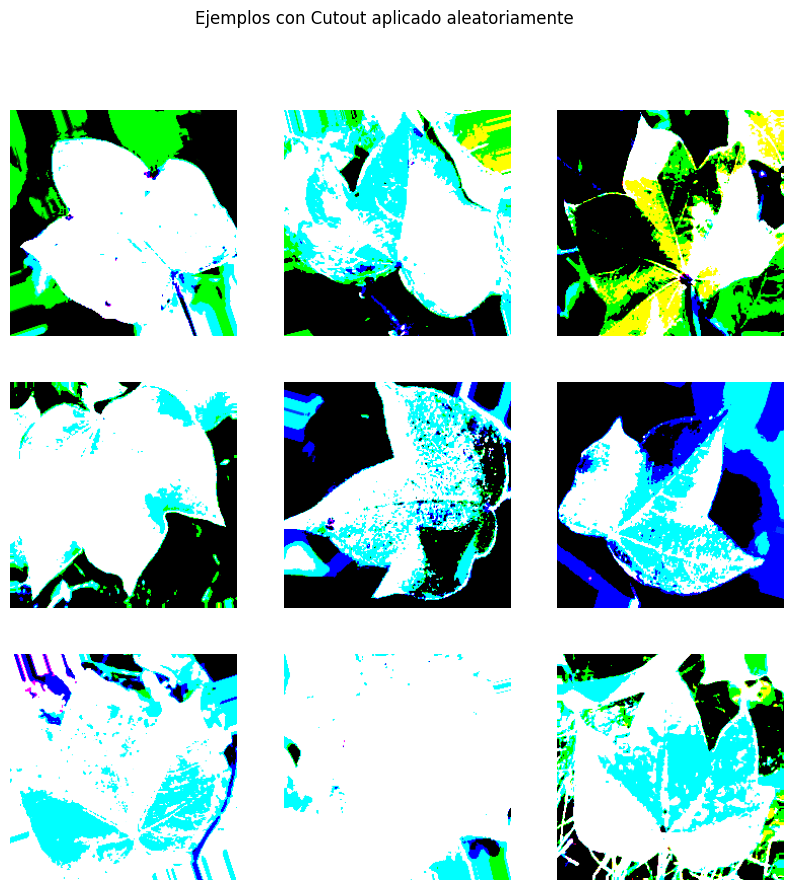

In [5]:
X, _ = next(generador_entrenamiento)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)  # Nota: i+1 para que los índices empiecen en 1
    plt.imshow(X[i])  # Añade cmap='gray' para imágenes en escala de grises
    plt.axis("off")
plt.suptitle("Ejemplos con Cutout aplicado aleatoriamente")
plt.show()

In [6]:
steps = len(generador_entrenamiento.filepaths) // generador_entrenamiento.batch_size
steps

80

In [7]:
learning_rate = INIT_LR

In [8]:
# Construccion del modelo
# --------------------------------------------------------------------------
def model_init(learning_rate, dropout_rate, l2_reg):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=INPUT_FORMAT)

    # for layer in base_model.layers:
    #     layer.trainable = False

    # aplicar fine tuning a partir de la capa bloque5_conv1
    for layer in base_model.layers:
        if layer.name.startswith('block5_conv1'):
            layer.trainable = True
        else:
            layer.trainable = False
    

    entrada = layers.Input(shape=INPUT_FORMAT)
    x = base_model(entrada)
    x = layers.Flatten()(x)
    x = BatchNormalization()(x)
    x = layers.Dense(
        256, activation="relu", kernel_regularizer=regularizers.l2(l2_reg)
    )(x)
    x = layers.Dropout(dropout_rate)(x)
    salida = layers.Dense(4, activation="softmax")(x)

    model = Model(inputs=entrada, outputs=salida)
    optimizador = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        loss="categorical_crossentropy", optimizer=optimizador, metrics=["accuracy"]
    )
    model.summary()
    return model

## optimizador bayesiano (aun no usarlo)

In [9]:
# from bayes_opt import BayesianOptimization
# from sklearn.model_selection import train_test_split
# import numpy as np


# # 1. Definir función objetivo a optimizar
# def optimize_model(lr, dropout_rate, l2_reg):
#     # Convertir parámetros
#     lr = 10**lr  # Usar escala logarítmica
#     l2_reg = 10**l2_reg

#     # Construir modelo con hiperparámetros actuales
#     modelo = model_init(learning_rate=lr, dropout_rate=dropout_rate, l2_reg=l2_reg)

#     # Entrenamiento reducido para evaluación rápida
#     history = modelo.fit(
#         generador_entrenamiento,
#         validation_data=generador_validacion,
#         epochs=3,
#         verbose=1,
#     )

#     # Retornar el mejor valor de val_accuracy
#     return np.max(history.history["val_accuracy"])


# # 2. Definir espacio de búsqueda
# pbounds = {
#     "lr": (-5, -2),  # 10^-5 a 10^-3
#     "dropout_rate": (0.7, 0.9),
#     "l2_reg": (-5, -2),  # 10^-5 a 10^-2
# }

# # 3. Crear optimizador bayesiano
# optimizer = BayesianOptimization(
#     f=optimize_model, pbounds=pbounds, random_state=42, verbose=1
# )

# # 4. Ejecutar optimización
# optimizer.maximize(
#     init_points=2,  # Exploración inicial aleatoria
#     n_iter=10,  # Iteraciones bayesianas
# )

In [10]:
# optimizer.max["params"]

In [11]:
# Obtener mejores parámetros
# best_params = optimizer.max["params"]

In [12]:
# Configuración de callbacks
import os

path_models = "./models/VGG16/"
os.makedirs(path_models, exist_ok=True)
arch = "VGG16"

## entrenamiento

In [13]:
model = model_init(learning_rate, 0.5, 1e-3)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,238,852 (81.02 MB)

 Trainable params: 8,833,796 (33.70 MB)

 Non-trainable params: 12,405,056 (47.32 MB)

In [ ]:
# # Ruta donde se guardará el archivo (ej: 'C:/Users/tu_usuario/proyecto/resultados/hiperparametros.txt')
# ruta_archivo = path_models + "hiperparametros.txt"  # ¡Cambia esto!

# # Asegurarse de que la carpeta exista (si no, la crea)
# os.makedirs(os.path.dirname(ruta_archivo), exist_ok=True)

# # Guardar en formato legible (clave = valor)
# with open(ruta_archivo, "w") as f:
#     for key, value in best_params.items():
#         f.write(f"{key} = {value}\n")

# print(f"¡Hiperparámetros guardados en: {ruta_archivo}!")

In [14]:
checkpoint = ModelCheckpoint(
    path_models + "model_vgg16.weights.h5",
    monitor="val_loss",  # <-- Guarda el mejor modelo basado en val_loss (más estable que val_accuracy)
    verbose=1,
    save_best_only=True,  # guarda cuando haya mejoras
    save_weights_only=True,
    mode="min",  # estaba en auto
)

early = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=10,  # <-- Detén el entrenamiento cuando val_accuracy no mejore en 10 EPOCHS
    verbose=1,
    restore_best_weights=True,
    mode="max",
)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitorear pérdida de validación
    mode="min",  # Reducir LR cuando val_loss deje de disminuir
    factor=0.5,  # Reducción moderada del LR
    patience=5,  # Esperar 5 EPOCHS sin mejora
    verbose=1,
    min_lr=1e-6,  # LR mínimo permitido+
)

# Añadir a los callbacks
callbacks = [checkpoint, reduce_lr]  # <-- Añadido

In [15]:
historia = model.fit(
    generador_entrenamiento,
    # steps_per_epoch=generador_entrenamiento.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=generador_validacion,
    # validation_steps=generador_validacion.samples // BATCH_SIZE,
    callbacks=callbacks,
    # class_weight=class_weights  # <-- Añadir esto
)

model.save(path_models + arch + "/model_vgg16.h5")

Epoch 1/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5059 - loss: 1.8199
Epoch 1: val_loss improved from None to 1.26319, saving model to ./models/VGG16/model_vgg16.weights.h5
81/81 ━━━━━━━━━━━━━━━━━━━━ 320s 4s/step - accuracy: 0.6136 - loss: 1.4342 - val_accuracy: 0.7000 - val_loss: 1.2632 - learning_rate: 1.0000e-04
Epoch 2/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7641 - loss: 1.0210
Epoch 2: val_loss did not improve from 1.26319
81/81 ━━━━━━━━━━━━━━━━━━━━ 248s 3s/step - accuracy: 0.7899 - loss: 0.9679 - val_accuracy: 0.7083 - val_loss: 1.3836 - learning_rate: 1.0000e-04
Epoch 3/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8555 - loss: 0.8395
Epoch 3: val_loss improved from 1.26319 to 1.18138, saving model to ./models/VGG16/model_vgg16.weights.h5
81/81 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.8595 - loss: 0.8180 - val_accuracy: 0.7250 - val_loss: 1.1814 - learning_rate: 1.0000e-04
Epoch 4/150
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy

Learning rate actual: 9.999999974752427e-07


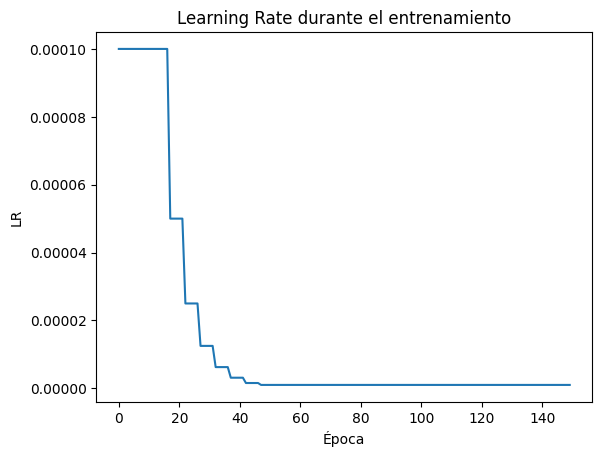

In [16]:
current_lr = model.optimizer.learning_rate.numpy()
print(f"Learning rate actual: {current_lr}")

# Graficar el learning rate a lo largo de las épocas
plt.plot(historia.history["learning_rate"])
plt.title("Learning Rate durante el entrenamiento")
plt.xlabel("Época")
plt.ylabel("LR")
plt.savefig(path_models + "VGG16_lr_plot.png")
plt.show()

In [17]:
model.save(path_models + arch + "/model_VGG16_arch.h5")

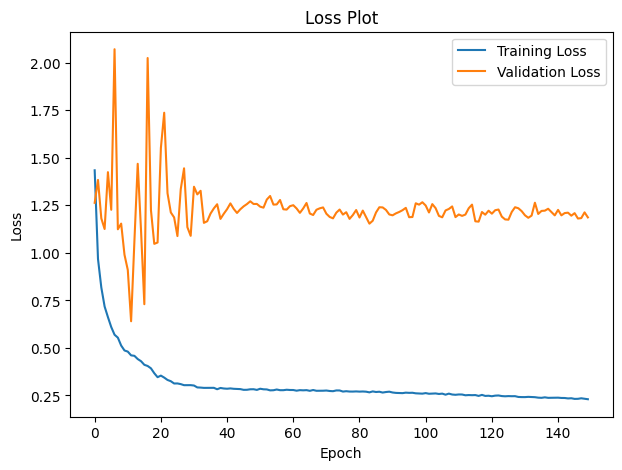

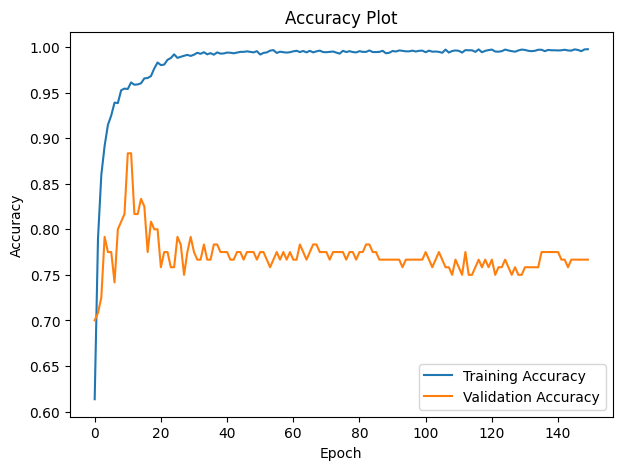

In [18]:
# Gráfico de Pérdida
plt.figure(figsize=(7, 5))
plt.plot(historia.history["loss"], label="Training Loss")
plt.plot(historia.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss Plot")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path_models + "VGG16_loss_plot.png")  # Guarda el gráfico en loss_plot.png
plt.show()

# Gráfico de Precisión
plt.figure(figsize=(7, 5))
plt.plot(historia.history["accuracy"], label="Training Accuracy")
plt.plot(historia.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Plot")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig(
    path_models + "VGG16_accuracy_plot.png"
)  # Guarda el gráfico en accuracy_plot.png
plt.show()

In [19]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Evaluación sobre el set de prueba
y_pred = model.predict(generador_test, verbose=1)
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = generador_test.classes

# Calcular métricas
cm = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

categories = [
    "Fresh_Leaf",
    "Leaf_Reddening",
    "Leaf_Spot_Bacterial_Blight",
    "Yellowish_Leaf",
]

# Crear la gráfica de la matriz de confusión
sns.set(font_scale=1.4)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="g",
    cmap="Pastel1_r",
    xticklabels=categories,
    yticklabels=categories,
)
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig(
    path_models + "VGG16_confusion_matrix.png"
)  # Guarda la imagen en un archivo PNG
plt.close()  # Cierra la figura

class_counts = cm.sum(axis=1)  # número total de instancias reales por clase
diag = np.diag(cm)  # verdaderos positivos por clase
class_accuracy = diag / class_counts

# Tabla en pandas
df = pd.DataFrame(
    {
        "Clase": categories,
        "Accuracy": class_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
    }
)

# Imprimir en pantalla (opcional)
print(f"Accuracy: {accuracy}")
print(df)
print("Average Precision:", df["Precision"].mean())
print("Average Recall:", df["Recall"].mean())
print("Average F1-Score:", df["F1-Score"].mean())

# Guardar las métricas en un archivo de texto
with open(path_models + "VGG16_metrics.txt", "w") as f:
    f.write(f"Accuracy: {accuracy}\n\n")
    f.write("Confusion Matrix:\n")
    f.write(np.array2string(cm))
    f.write("\n\nMetrics Table:\n")
    f.write(df.to_string(index=False))
    f.write("\n\n")
    f.write(f"Average Precision: {df['Precision'].mean()}\n")
    f.write(f"Average Recall: {df['Recall'].mean()}\n")
    f.write(f"Average F1-Score: {df['F1-Score'].mean()}\n")

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
Accuracy: 0.8166666666666667
                        Clase  Accuracy  Precision    Recall  F1-Score
0                  Fresh_Leaf  0.966667   0.725000  0.966667  0.828571
1              Leaf_Reddening  0.733333   0.916667  0.733333  0.814815
2  Leaf_Spot_Bacterial_Blight  1.000000   0.789474  1.000000  0.882353
3              Yellowish_Leaf  0.566667   0.944444  0.566667  0.708333
Average Precision: 0.8438961988304094
Average Recall: 0.8166666666666667
Average F1-Score: 0.8085181294740119
